In [1]:
import pandas as pd
import akshare as ak
import seaborn as sns
import arch
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from arch import arch_model
warnings.filterwarnings('ignore')
sns.set(font='SimHei')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
df = ak.stock_zh_a_spot_em()
df.to_excel('example1.xlsx', sheet_name='Sheet1', index=False)

In [2]:
import pandas as pd
import akshare as ak
df=ak.stock_zh_a_hist(symbol='688256', period='daily', start_date='20230601', end_date='20240601', adjust='qfq')
df.to_csv('688256b.csv',index=False)

In [3]:
df['date']=pd.to_datetime(df['日期'])
df=df.set_index('date')

In [4]:
ret=100*df['收盘'].pct_change().dropna()

In [5]:
from statsmodels.tsa.stattools import adfuller #ADF单位根检验
result = adfuller(ret) #不能拒绝原假设，即原序列存在单位根
print(result)

(-12.594123198671136, 1.794333275142076e-23, 1, 239, {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}, 1329.7054340685588)


划分训练集和预测部分

In [6]:
ret_train=ret[ret.index<'2024-05-01']
ret_test=ret[ret.index>='2024-05-01']

建立简单arch模型，进行arch效应检验

In [7]:
t1=arch.arch_model(ret_train, mean="Constant", vol="ARCH", p=1)
result=t1.fit(disp="off")

In [8]:
result

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                     收盘   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -659.821
Distribution:                  Normal   AIC:                           1325.64
Method:            Maximum Likelihood   BIC:                           1335.84
                                        No. Observations:                  221
Date:                Mon, Jun 17 2024   Df Residuals:                      220
Time:                        23:02:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0108      0.299 -3.624e-02      0.971 [ -0.596,  0.57

In [9]:
result.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 20.2391
P-value: 0.1630
Distributed: chi2(15)
WaldTestStatistic, id: 0x1f0d59d1610

In [10]:
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro

In [11]:
# 模型优化
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in range(len(p_rng)):
        for q in range(len(q_rng)):
            model = arch_model(data, vol='GARCH', p=p_rng[p], q=q_rng[q], dist='normal')
            model_fit = model.fit(disp='off')
            resid = model_fit.resid
            st_resid = np.divide(resid, model_fit.conditional_volatility)
            results = evaluate_model(resid, st_resid)
            results['AIC'] = model_fit.aic
            results['params']['p'] = p+1
            results['params']['q'] = q+1
            print(model_fit.aic)
            if results['AIC'] < top_score:
                top_score = results['AIC']
                top_results = results

    top_models.append(top_results)
    return top_models


# 模型评估
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }

    arch_test = het_arch(residuals, nlags=lags)
    shap_test = shapiro(st_residuals)

    results['LM_pvalue'] = [arch_test[1], arch_test[1] < 0.05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < 0.05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < 0.05]

    return results


p_rng = list(range(1, 5)) 
q_rng = list(range(1, 5)) 
top_models = gridsearch(ret_train, p_rng, q_rng)
print('*****************top_models*******************')
print(top_models)

1319.9513632406497
1321.9513636057409
1323.951363232573
1325.9513634970544
1320.002638086355
1322.0026383113072
1324.0026385973133
1326.002638145761
1320.3061559324044
1322.3061563979281
1324.3061561696575
1326.3061559064183
1321.9103805002492
1323.9103804854826
1325.9103806184007
1327.9103806159624
*****************top_models*******************
[{'LM_pvalue': [0.9693417187488792, False], 'F_pvalue': [0.9858565315082538, False], 'SW_pvalue': [5.4793454182799906e-06, True], 'AIC': 1319.9513632406497, 'params': {'p': 1, 'q': 1}}]


In [12]:
garch_model_1=arch.arch_model(ret_train,vol='GARCH',p=3,q=3)
garch_result=garch_model_1.fit(disp="off")

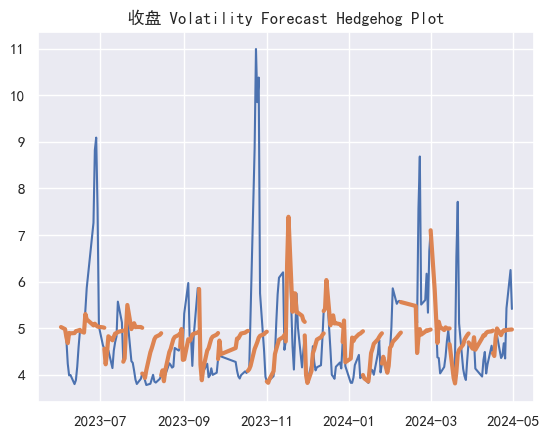

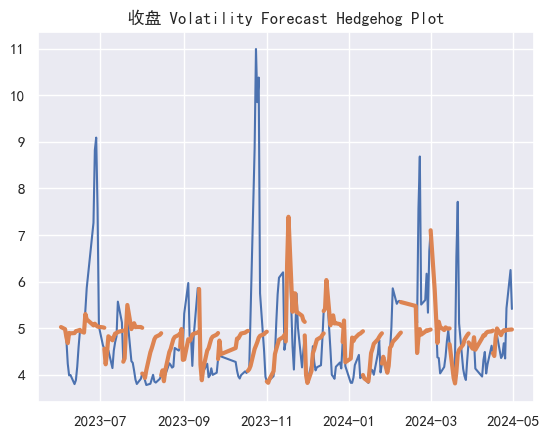

In [13]:
garch_result.hedgehog_plot()

In [14]:
forecasts_train = garch_result.forecast(start=0,horizon=1)
forecasts_train.residual_variance

,h.1
date,
2023-06-02,24.799597
2023-06-05,22.460179
2023-06-06,17.948498
2023-06-07,15.893940
2023-06-08,15.963606
...,...
2024-04-24,18.927652
2024-04-25,29.464668
2024-04-26,39.042069


In [15]:
forecast_test=garch_result.forecast(horizon=len(ret_test))

In [16]:
tmp=forecast_test.residual_variance.dropna().T
tmp2=tmp[tmp.columns[0]].values.tolist()
future=pd.DataFrame(tmp2)
future.columns=['h.1']
future.index=ret_test.index

In [17]:
forecasts_train.residual_variance

,h.1
date,
2023-06-02,24.799597
2023-06-05,22.460179
2023-06-06,17.948498
2023-06-07,15.893940
2023-06-08,15.963606
...,...
2024-04-24,18.927652
2024-04-25,29.464668
2024-04-26,39.042069


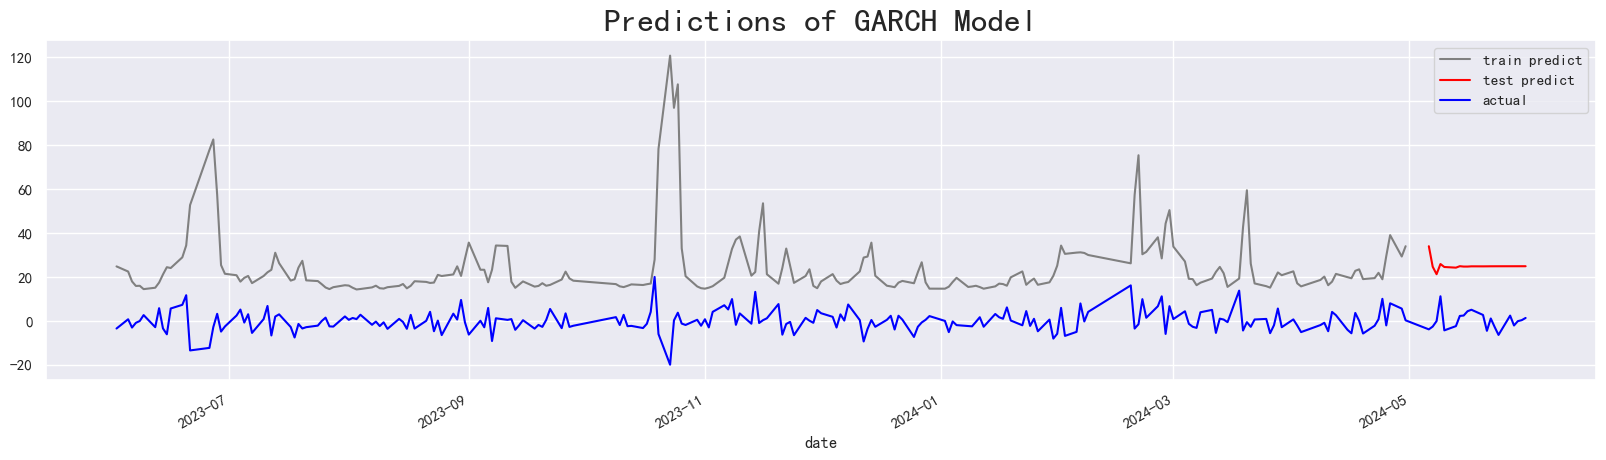

In [18]:
plt.figure(figsize=(20,5))
plt.plot(forecasts_train.residual_variance.index,forecasts_train.residual_variance.values,color='gray')
plt.plot(future.index,future[future.columns[0]],color='red')
ret.plot(color = "blue", zorder = 3)
plt.title("Predictions of GARCH Model", size=24)
plt.legend(['train predict','test predict','actual'])
plt.show()

In [19]:
am = arch_model(ret, vol="arch", p=3, o=0, q=3, dist="skewt")
res = am.fit(disp="off")

In [20]:
forecasts = res.forecast(start=0)
cond_mean = forecasts.mean.dropna()
cond_var = forecasts.variance.dropna()
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.07834723 -1.40079994]


In [21]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)

In [22]:
for col in value_at_risk.columns:
    value_at_risk[col]=-value_at_risk[col]

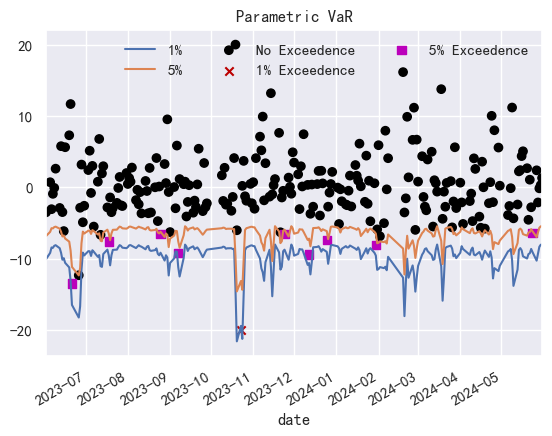

In [23]:
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = ret.copy()
rets_2018.name = "S&P 500 Return"


c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

In [24]:
forecasts_train.residual_variance

,h.1
date,
2023-06-02,24.799597
2023-06-05,22.460179
2023-06-06,17.948498
2023-06-07,15.893940
2023-06-08,15.963606
...,...
2024-04-24,18.927652
2024-04-25,29.464668
2024-04-26,39.042069


In [25]:
t=pd.DataFrame(future)
t.columns=['h.1']

In [26]:
vol=forecasts_train.residual_variance._append(t)

In [27]:
vol['ret']=ret

<Axes: xlabel='date'>

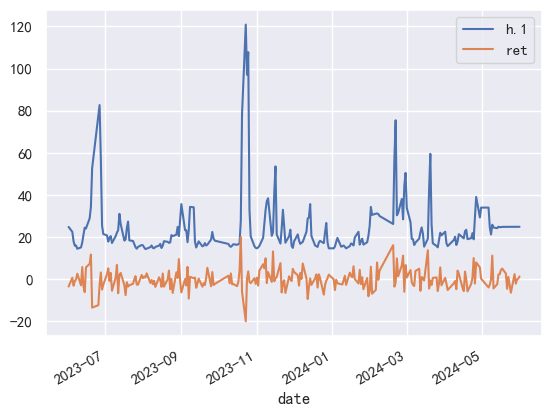

In [28]:
vol.plot()

In [29]:
vol_tmp=vol[vol.index>='2024-05-01']

In [30]:
total=[]
first_price=df['收盘'].values.tolist()[-25]
next_price=first_price
for val in vol_tmp['h.1'].values.tolist():
    next_price=(1+(val/100))*next_price
    total.append(next_price)      

In [31]:
vol_tmp['h.1'].values.tolist()

[33.991721159677155,
 24.63901430334706,
 21.237760583095792,
 25.880842944707325,
 24.52340729209014,
 24.23016037584305,
 24.89142800959174,
 24.720408251500245,
 24.721083637389686,
 24.827369545321968,
 24.81602975982021,
 24.82897386107644,
 24.85106333560408,
 24.855316779199377,
 24.861924785944996,
 24.868284011097714,
 24.87140515634936,
 24.874275193162003,
 24.876580427899313,
 24.878091583144936]

In [32]:
df_tmp=df[df.index>='2024-05-01']
df_tmp['pred_garch']=total
df

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
date,,,,,,,,,,,,
2023-06-01,2023-06-01,688256,248.00,237.01,259.24,237.00,121860,3.007753e+09,8.75,-6.76,-17.18,5.00
2023-06-02,2023-06-02,688256,241.00,228.70,244.58,224.84,118296,2.732752e+09,8.33,-3.51,-8.31,4.86
2023-06-05,2023-06-05,688256,227.70,230.32,235.24,225.00,89765,2.066278e+09,4.48,0.71,1.62,3.68
2023-06-06,2023-06-06,688256,227.00,223.25,232.18,219.00,91596,2.059426e+09,5.72,-3.07,-7.07,3.75
2023-06-07,2023-06-07,688256,221.09,221.20,226.53,217.12,71106,1.572973e+09,4.22,-0.92,-2.05,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,2024-05-27,688256,170.00,175.99,177.60,165.98,98148,1.687678e+09,6.76,2.38,4.09,2.36
2024-05-28,2024-05-28,688256,174.51,172.25,183.00,172.00,80918,1.428303e+09,6.25,-2.13,-3.74,1.94
2024-05-29,2024-05-29,688256,174.30,172.00,178.64,170.11,57707,1.005904e+09,4.95,-0.15,-0.25,1.39


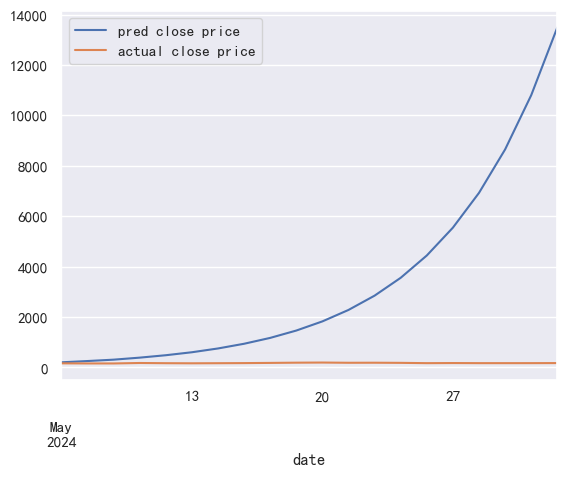

In [33]:
df_tmp['pred_garch'].plot()
df_tmp['收盘'].plot()
plt.legend(['pred close price','actual close price'])